# HumBug data processing

### Note, this notebook contains two sets of functions for processing data. One is concerned with labels from the Culex labelled dataset. The other, with suffix _cdc, is currently in place to experiment with the algorithm in unlabelled datasets

The functions associated with the CDC dataset require some building blocks from the culex data functions.

A minimal working example (for the hand-labelled Culex set) consists of running all the cells sequentially in Section 1, and is highly recommended for validating operation of every code block.

`CNNBirdClef.ipynb` is then used for visualising network filters and other features in more depth

In [2]:
#import audacity
import numpy as np
import sys 
import os, os.path
from scipy.io.wavfile import read, write
from scipy import signal
from scipy import nanmean
from scipy.signal import medfilt


import csv
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from collections import Counter

import random

# Keras-related imports
from keras.models import Sequential
from keras.regularizers import WeightRegularizer
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Convolution1D, MaxPooling2D, Convolution2D
from keras import backend as K
K.set_image_dim_ordering('th')
from keras.callbacks import ModelCheckpoint
from keras.callbacks import RemoteMonitor
from keras.callbacks import EarlyStopping
from keras.models import load_model

# Data post-processing and analysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score

import itertools
from scipy.signal import find_peaks_cwt

sys.path.append('lib')
#sys.path.append('lib/kiswav')
import proc_data_lib as detector_lib

# Optional: LaTeX cm font (slow)
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

Using Theano backend.


In [3]:
# Culex data (labelled with data_dz_corrob etc.)
data_path = 'data/Culex Quinquefasciatus/audio/'
label_path = 'data/Culex Quinquefasciatus/labels/'

signal_list, label_list, label_names, fs = detector_lib.import_file(data_path, label_path)





Processing 0001_norm.wav
Processing 0002_norm.wav
Processing 0003_norm.wav
Processing 0004_norm.wav
Processing 0005_norm.wav
Processing 0006_norm.wav
Processing 0007_norm.wav
Processing 0008_norm.wav
Processing 0009_norm.wav
Processing 0010_norm.wav
Processing 0011_norm.wav
Processing 0012_norm.wav
Processing 0013_norm.wav
Processing 0014_norm.wav
Processing 0015_norm.wav
Processing 0016_norm.wav
Processing 0017_norm.wav
Processing 0018_norm.wav
Processing 0019_norm.wav
Processing 0020_norm.wav
Processing 0021_norm.wav
Processing 0022_norm.wav
Processing 0023_norm.wav
Processing 0024_norm.wav
Processing 0025_norm.wav
Processing 0026_norm.wav
Processing 0027_norm.wav
Processing 0028_norm.wav
Processing 0029_norm.wav
Processing 0030_norm.wav
Processing 0031_norm.wav
Processing 0032_norm.wav
Processing 0033_norm.wav
Processing 0034_norm.wav
Processing 0035_norm.wav
Processing 0036_norm.wav
Processing 0037_norm.wav
Processing 0038_norm.wav
Processing 0039_norm.wav
Processing 0040_norm.wav


The gold standard label is given by `select_label = 5`.


If implementing a sort of majority voting (`maj_vote = True`), specify the `count_method` with a string. Options are:

`'most_positive'`: If any label contains a positive, assign a label of +1

`'two_or_more'`: if two or more labels agree, assign that label

`'agreement'`: only assign samples where each label agrees.

Any other string will result in a ValueError.

In [ ]:
detector_lib.

In [4]:
t = detector_lib.proc_label(signal_list = signal_list, label_list = label_list)

NameError: global name 'label_names' is not defined

In [5]:
# # Specify whether data to be used in convnet or MLP
conv = True

# Code for withholding signals for test purposes. Mainly for visual comparisons with existing detectors in MozzPy

spec_window = 10

n_fft = 512
n_overlap = 256

test_idx = np.array([1,5,19,11,17,18,19,24,28,30,32,35,36,37,38,42,45,49,56,57]) - 1 # Corrected for index convention
train_idx = np.arange(57)
train_idx = np.delete(train_idx, test_idx)

test_x = []
test_t = []
train_x = []
train_t = []

for idx in test_idx:
    test_x.append(signal_list[idx])
    test_t.append(t[idx])

for idx in train_idx:
    train_x.append(signal_list[idx])
    train_t.append(t[idx])

x_test_spec, y_test_spec, input_shape, spec_freq = detector_lib.proc_data_humbug(test_x, test_t, fs, n_fft/2,spec_window,
                                                          nfft = n_fft, overlap = n_overlap)
x_train_spec, y_train_spec, input_shape, spec_freq = detector_lib.proc_data_humbug(train_x, train_t, fs, n_fft/2,spec_window,
                                                                        nfft = n_fft, overlap = n_overlap)

# Reshape data for MLP
if not conv:
    x_train_spec = x_train_spec.reshape(x_train_spec.shape[0], x_train_spec.shape[-2]*x_train_spec.shape[-1])
    x_test_spec = x_test_spec.reshape(x_test_spec.shape[0], x_test_spec.shape[-2]*x_test_spec.shape[-1])

NameError: name 't' is not defined

## Neural network execution

### Data prep

Left in this code block to show the syntax for combining training data from different domains. Will correctly concatenate as long as the parameters used in proc_data_humbug and proc_data_humbug_cdc are equivalent.

### Parameterise network as necessary
For details on parameters, see documentation at:
https://keras.io/getting-started/sequential-model-guide/

and a further example on:
https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py

In [350]:
## NN parameters

# number of convolutional filters
nb_conv_filters = 32
num_hidden = 256
n_dense = 128

arbitrary = 1
# size of pooling area for max pooling
pool_size = (2,2)

# convolution kernel size 
kernel_size_1 = (3,3)
kernel_size_2 = (3,3)
# number of classes
nb_classes = 2

# Initialise model

model = Sequential()

if conv:
    input_shape = (1, x_train.shape[2], x_train.shape[-1])

    model.add(Convolution2D(nb_conv_filters, kernel_size_1[0], kernel_size_1[1],
                           border_mode = 'valid',
                           input_shape = input_shape))
    convout1 = Activation('relu')
    model.add(convout1)
#     model.add(Convolution2D(nb_filters/2, kernel_size_2[0], kernel_size_2[1]))

#     convout2 = Activation('relu')
#     model.add(convout2)
#     model.add(MaxPooling2D(pool_size = pool_size))
#     model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Activation('relu'))

else:    # Fully connected first layer to replace conv layer
    # N.B. Not sure exactly if this is the number of units in the hidden layer
    #n_hidden = 16
    model.add(Dense(num_hidden, input_dim=np.shape(x_train_caged)[1]))
    model.add(Activation('relu'))
    #model.add(Dense(128))
    #model.add(Activation('relu'))
    #model.add(Dense(128))
    #model.add(Activation('relu'))
model.add(Dense(n_dense))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

In [351]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_5 (Convolution2D)  (None, 32, 254, 8)    320         convolution2d_input_16[0][0]     
____________________________________________________________________________________________________
activation_17 (Activation)       (None, 32, 254, 8)    0           convolution2d_5[0][0]            
____________________________________________________________________________________________________
flatten_5 (Flatten)              (None, 65024)         0           activation_17[0][0]              
____________________________________________________________________________________________________
activation_18 (Activation)       (None, 65024)         0           flatten_5[0][0]                  
___________________________________________________________________________________________

In [138]:
# Data re-shaping for MLP

print np.shape(x_train_wav), np.shape(x_train_spec)
x_train = np.zeros([x_train_wav.shape[0], x_train_wav.shape[1], x_train_wav.shape[2] + x_train_spec.shape[2], x_train_wav.shape[3]])
#x_train = np.vstack([x_train_wav, x_train_spec])
print np.shape(x_train)
x_train[:,:,:80,:] = x_train_wav
x_train[:,:,80:,:] = x_train_spec
y_test = y_test_wav
conv = False
x_test = np.zeros([x_test_wav.shape[0], x_test_wav.shape[-1]*x_test_wav.shape[-2] + x_test_spec.shape[-1] * x_test_spec.shape[-2]])

x_test[:, :(x_test_wav.shape[-1]*x_test_wav.shape[-2])] = x_test_wav.reshape(x_test_wav.shape[0], x_test_wav.shape[-2]*x_test_wav.shape[-1])
x_test[:, (x_test_wav.shape[-1]*x_test_wav.shape[-2]):] = x_test_spec.reshape(x_test_spec.shape[0], x_test_spec.shape[-2]*x_test_spec.shape[-1])
print 'x test shape', np.shape(x_test)

(62282, 1, 247, 1) (6209, 2560)


IndexError: tuple index out of range

# TURN INTO FUNCTION FOR WAVELET RESHAPING AT A FIXED SCALE

squeezycakes (62282, 247)
cut_idx 62280
cut_idx 32840
[   0    1    2 ..., 6225 6226 6227]
[    0     1     2 ..., 62277 62278 62279]
training samples 62280 32840
interpolated wavelet labels 6228
(6228, 1, 247, 10)
(3284, 1, 247, 10)


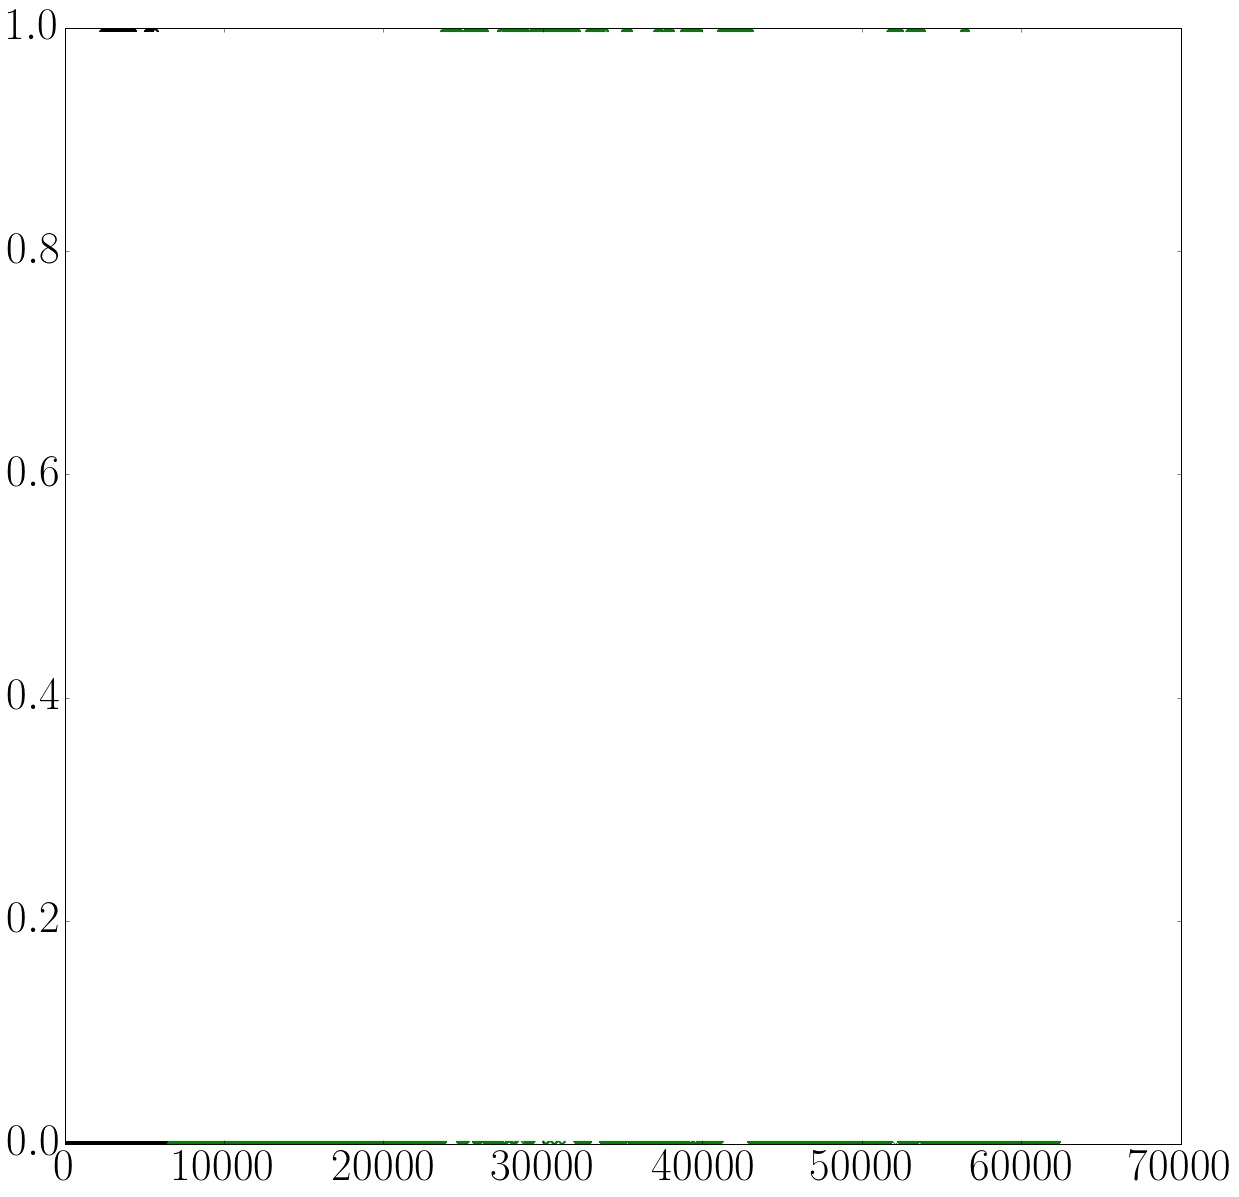

In [239]:
# Experimental code for reshaping wavelet into larger spectrogram windows, re-sampling labels, and preserving information 
# without need to re-run the wavelet transform


x_train_raw = np.squeeze(x_train_wav)
x_test_raw = np.squeeze(x_test_wav)


training_sample_length = 10
print 'squeezycakes', x_train_raw.shape
n_feats = np.shape(x_train_raw)[1]

cut_idx = (x_train_raw.shape[0]/training_sample_length) * training_sample_length
print 'cut_idx', cut_idx
x_train_cut = x_train_raw[:cut_idx,:]
y_train_cut = y_train_wav[:cut_idx]
cut_idx = (x_test_raw.shape[0]/training_sample_length) * training_sample_length
print 'cut_idx', cut_idx
x_test_cut = x_test_raw[:cut_idx,:]
y_test_cut = y_test_wav[:cut_idx]
x_train_caged = x_train_cut.reshape(x_train_cut.shape[0]/training_sample_length, x_train_cut.shape[1],
                                    training_sample_length)


x_test = x_test_cut.reshape(x_test_cut.shape[0]/training_sample_length, x_test_cut.shape[1],
                            training_sample_length)
print np.arange(len(x_train_caged))
print np.arange(len(y_train_cut))
y_train_pos = np.rint(np.interp(np.arange(len(x_train_caged))*10, np.arange(len(y_train_cut)), y_train_cut[:,0]))
y_train_neg = 1 - y_train_pos
print 'training samples', len(y_train_cut), len(y_test_cut)
#plt.plot(y_train_wav)
plt.figure(figsize = (20,20))
plt.plot(y_train_cut[:,0], 'gx')
print 'interpolated wavelet labels', len(y_train_pos)
plt.plot(y_train_pos, 'kx')



y_test_pos = np.rint(np.interp(np.arange(len(x_test))*10, np.arange(len(y_test_cut)), y_test_cut[:,0]))
y_test_neg = 1 - y_test_pos

y_train = np.vstack([y_train_pos,y_train_neg]).T
y_train_caged = y_train
y_test = np.vstack([y_test_pos,y_test_neg]).T


x_train = x_train_caged.reshape((np.shape(x_train_caged)[0],1,x_train_wav.shape[2],training_sample_length))
x_test = x_test.reshape((np.shape(x_test)[0],1,x_test_wav.shape[2],training_sample_length))

print x_train.shape
print x_test.shape

In [352]:
##################### Select conv or MLP ##########################
conv = True
save_weights = False
data_method = 'spec'

if data_method == 'wav':
    x_train_caged = x_train_wav
    y_train_caged = y_train_wav
    x_train = x_train_wav
    y_train = y_train_wav
    x_test = x_test_wav
    y_test= y_test_wav

elif data_method == 'spec':
    y_test = y_test_spec
    x_test = x_test_spec
    x_train = x_train_spec
    y_train = y_train_spec
    x_train_caged = x_train
    y_train_caged = y_train_spec
#input_shape = (1, x_train.shape[2], 10)

elif data_method == 'spec_cut':
    # Load wavelet for parameter matching
    data = np.load('Outputs/humbug_conv_wavelet_247_1_1_dz_interp.npz')
    print data.files
    # x_train_wav = data["x_train"]
    # y_train_wav = data["y_train"]
    # x_test_wav = data["x_test"]
    # y_test_wav = data["y_test"]
    wav_freq = data["wav_freq"]
    cut_freq = np.where(spec_freq > wav_freq[-1])[0]
    # Reshape for CNN
    if conv:
        x_train = x_train_spec[:,:,cut_freq,:]
        x_test = x_test_spec[:,:,cut_freq,:]
    # Reshape for MLP
    else:
        x_train = x_train_spec[:,cut_freq*spec_window]
        x_test = x_test_spec[:,cut_freq*spec_window]
        x_train_caged = x_train
    y_test = y_test_spec
    y_train = y_train_spec
    y_train_caged = y_train_spec
    print input_shape
    spec_freq = spec_freq[cut_freq]
elif data_method == 'raw':
    x_train_caged = x_train_raw
    y_train_caged = y_train_raw
    x_train = x_train_raw
    y_train = y_train_raw
    x_test = x_test_raw
    y_test= y_test_raw


batch_size = 256
nb_epoch = 20


##################### MLP execution Code ##########################
if not conv:
    nb_epoch = 20
    if x_train.ndim > 2:
        x_train_caged = x_train.reshape(x_train.shape[0], x_train.shape[-2]*x_train.shape[-1])
        x_test = x_test.reshape(x_test.shape[0], x_test.shape[-2]*x_test.shape[-1])
   
    if save_weights == False:
        early_stopping = EarlyStopping(monitor='acc', patience = 5, verbose=0, mode='auto')

        hist = model.fit(x_train_caged, y_train_caged, batch_size=batch_size, nb_epoch=nb_epoch, 
                  verbose=2, callbacks = [early_stopping])    

    #y_train_caged = y_train_wav
    if save_weights == True:    
        print np.shape(x_train_caged)
        Weights = np.zeros([nb_epoch,np.shape(x_train_caged)[1],n_hidden])
        for i in range(nb_epoch):
            print 'Epoch number', i+1, 'of', nb_epoch
            model.fit(x_train_caged, y_train_caged, batch_size=batch_size, validation_split = 0., nb_epoch=1, 
                      verbose=2)
            W = model.layers[0].W.get_value(borrow=True)
            Weights[i,:,:] = W
    


# filepath = "weights-improvement.hdf5"
# #filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"

# # Options to save best performing iteration according to monitor = ?. E.g. 'val_acc' will save the run with the highest 
# # validation accuracy.

# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max') 
# callbacks_list = [checkpoint]
# remote = RemoteMonitor(root='http://localhost:9000') # For viewing accuracy measures during training. Experimental.



##################### CNN execution code ##########################
if conv:
    print np.shape(x_train)
#    min_delta = 0.01, Value to use just in case current settings do not work well

    early_stopping = EarlyStopping(monitor='acc', patience = 5, verbose=0, mode='auto')

    hist = model.fit(x_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, 
              verbose=2, callbacks = [early_stopping])
    
    
#model.fit(x_train_caged, y_train_caged, batch_size=batch_size, nb_epoch=nb_epoch,
#         verbose=2)#,callbacks= [remote]) ## validation_data=(X_test_set, Y_test)
#RemoteMonitor(root='http://localhost:9000', path='/publish/epoch/end/', field='data', headers={'Content-Type': 'application/json', 'Accept': 'application/json'})



(6209, 1, 256, 10)
Epoch 1/20
16s - loss: 5.3099 - acc: 0.6473
Epoch 2/20
15s - loss: 2.8747 - acc: 0.8024
Epoch 3/20
13s - loss: 2.4483 - acc: 0.8325
Epoch 4/20
15s - loss: 2.0193 - acc: 0.8575
Epoch 5/20
13s - loss: 2.1644 - acc: 0.8513
Epoch 6/20
14s - loss: 1.7958 - acc: 0.8745
Epoch 7/20
14s - loss: 1.8254 - acc: 0.8708
Epoch 8/20
14s - loss: 1.8487 - acc: 0.8705
Epoch 9/20
14s - loss: 1.8612 - acc: 0.8713
Epoch 10/20
15s - loss: 1.5282 - acc: 0.8935
Epoch 11/20
15s - loss: 1.4629 - acc: 0.8958
Epoch 12/20
13s - loss: 1.4519 - acc: 0.8971
Epoch 13/20
15s - loss: 1.7330 - acc: 0.8792
Epoch 14/20
13s - loss: 1.4522 - acc: 0.8982
Epoch 15/20
14s - loss: 1.7061 - acc: 0.8832
Epoch 16/20
14s - loss: 1.9241 - acc: 0.8702
Epoch 17/20
14s - loss: 1.5726 - acc: 0.8919
Epoch 18/20
14s - loss: 2.1994 - acc: 0.8505
Epoch 19/20
13s - loss: 2.4060 - acc: 0.8385
Epoch 20/20
14s - loss: 1.6254 - acc: 0.8890


In [271]:
binning_method = 'interp'
# Set file name for wavelet
base_name = 'humbug'
suffix_2 = 'wavelet'
if conv:
    suffix = 'conv'
else:
    suffix = 'MLP'
model_name = (base_name + '_' + suffix + '_' + suffix_2 + '_' + str(len(wav_freq)) + '_' + str(nb_conv_filters) + '_' + 
              str(n_dense) + '_'
              + str(kernel_size_1[0]) + '_' + str(kernel_size_1[0]) + '_' + str(spec_window) + '_' + count_method + '_' + binning_method)
print model_name

humbug_MLP_wavelet_247_32_1024_3_3_10_dz_interp


In [261]:
# Set name for file saving

base_name = 'humbug'
if conv:
    suffix = 'conv'
else:
    suffix = 'MLP'

model_name = (base_name + '_' + suffix + '_' + str(n_fft) + '_' + str(n_overlap) + '_' + str(nb_conv_filters) + '_' + 
              str(n_dense) + '_'
              + str(kernel_size_1[0]) + '_' + str(kernel_size_1[0]) + '_' + str(spec_window) + '_' + count_method)
print 'model_name:', model_name

model_name: humbug_MLP_512_256_32_1024_3_3_10_dz


Code to generate predictions. Note that in a practical implementation on a phone, we will only need to (pre)load a model once, and predict over a test dataset x_test. The test dataset is constructed from sectioning a spectrogram according to proc_data_humbug.

### Functions necessary for predictions end here. The remaining functions and scripts in Section 1 are for performance analysis and visualisation

('Test score:', 1.9097167752505704)
('Test accuracy:', 0.86621869276701569)
True positive rate 0.692722371968 True negative rate 0.955576122166


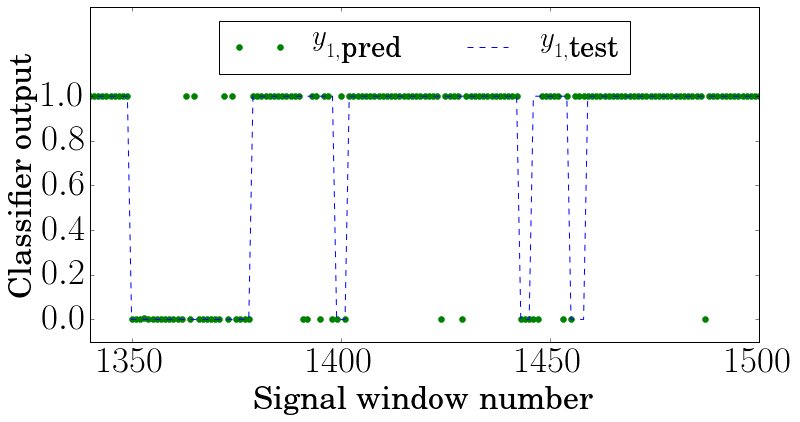

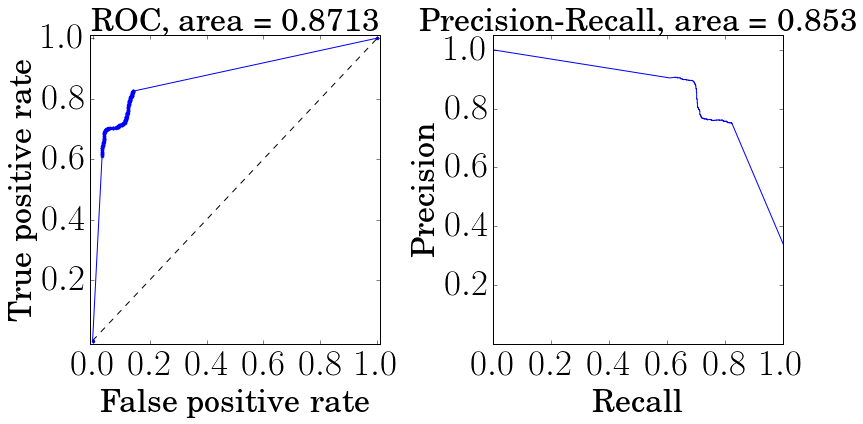

F1 score 0.778787878788


In [356]:
# IMPORTANT: DO NOT OVERWRITE FIGURES #

eval_model = True

#####################################################################################


save_fig = 'publication'
save_fig_individual = False

font_size = 32
font_size_legend = 29
label_size = 37
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size 
#plt.rcParams['']

#####################################################################################

if eval_model:
    score = model.evaluate(x_test, y_test, verbose=2)
    predictions = model.predict(x_test)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

########### 2 class predictions #####################################################
positive_predictions = predictions[:,0][np.where(y_test[:,0])]
negative_predictions = predictions[:,1][np.where(y_test[:,1])]

true_positive_rate = (sum(np.round(positive_predictions)))/sum(y_test[:,0])
true_negative_rate = sum(np.round(negative_predictions))/sum(y_test[:,1])



figs = []

f = plt.figure(figsize = (12,6))
plt.plot(predictions[:,0],'g.', markersize = 12, label = '$y_{1, \\textrm{pred}}$')
plt.plot(y_test[:,0], '--b', linewidth = 1, markersize = 2, label = '$y_{1, \\textrm{test}}$')
    
plt.legend(loc = 9, fontsize = font_size_legend, ncol = 2)

plt.ylim([-0.1,1.4])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xlim([1340, 1500])
plt.xticks([1350, 1400, 1450, 1500])
plt.ylabel('Classifier output', fontsize = font_size )
plt.xlabel('Signal window number', fontsize = font_size)
if save_fig == 'publication_softmax':
    plt.tight_layout()
    plt.savefig('../../../TexFiles/Papers/ECML/Images/softmax_' + model_name + '.pdf')
    
if save_fig_individual:
    plt.savefig('Outputs/' + 'solo_softmax_' + model_name + '.pdf')

figs.append(f)
print 'True positive rate', true_positive_rate, 'True negative rate', true_negative_rate

#plt.savefig('Outputs/' + 'ClassOutput_' + model_name + '.pdf', transparent = True)
#print 'saved as', 'ClassOutput_' + model_name + '.pdf' 
#plt.show()


cnf_matrix = confusion_matrix(y_test[:,1], np.round(predictions[:,1]).astype(int))
class_names = ('Mozz','No mozz')
# Plot normalized confusion matrix

f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

y_true = y_test[:,0]
y_score = predictions[:,0]
roc_score = roc_auc_score(y_true, y_score)
fpr, tpr, thresholds = roc_curve(y_true, y_score)


#plt.subplot(1,2,2)
#plt.figure(figsize=(4,4))
ax1.plot(fpr, tpr, '.-')
ax1.plot([0,1],[0,1],'k--')
ax1.set_xlim([-0.01, 1.01])
ax1.set_ylim([-0.01, 1.01])
ax1.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_xlabel('False positive rate',fontsize = font_size )
ax1.set_ylabel('True positive rate',fontsize = font_size )
ax1.set_title('ROC, area = %.4f'%roc_score, fontsize = font_size )

if save_fig_individual:
    plt.savefig('Outputs/' + 'solo_ROC_' + model_name + '.pdf')



y_test_pr = y_test[:,0]

precision = dict()
recall = dict()
average_precision = dict()
for i in range(1):
    precision[i], recall[i], _ = precision_recall_curve(y_test_pr,
                                                        y_score)
    average_precision[i] = average_precision_score(y_test_pr, y_score)

# Plot Precision-Recall curve
#plt.clf()
ax2.plot(recall[0], precision[0], color='b',
         label='Precision-Recall curve')
ax2.set_xlabel('Recall',fontsize = font_size )
ax2.set_ylabel('Precision',fontsize = font_size )
ax2.set_ylim([0.0, 1.05])
ax2.set_xlim([0.0, 1.0])
ax2.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax2.set_title('Precision-Recall, area = {0:0.3f}'.format(average_precision[0]),fontsize = font_size )
#plt.legend(loc="lower left")
if save_fig == 'publication':
    plt.tight_layout()
    plt.savefig('../../../TexFiles/Papers/ECML/Images/metric_' + model_name + '.pdf')
plt.show()
    
F1 = f1_score(np.round(predictions[:,0]), y_test[:,0], average='binary')  
print 'F1 score', F1    

################ MEDIAN FILTERING ###########################################
    

# kernel_size = 31
# plt.figure()
# print 'MEDIAN FILTERED RESULTS'
# plt.plot(predictions[:,0],'.', label = 'original')
# filt_predictions = np.zeros(np.shape(predictions))
# filt_predictions[:,0] = medfilt(predictions[:,0], kernel_size = kernel_size)
# filt_predictions[:,1] = 1 - filt_predictions[:,0]
# plt.plot(filt_predictions[:,0],'.', label = 'filtered')
# plt.legend()

# ## Repeat decision process

# F1 = f1_score(np.round(filt_predictions[:,0]), y_test[:,0], average='binary')  
# print 'F1 median filter score', F1

# ########### 2 class predictions #####################################################
# positive_predictions_filt = filt_predictions[:,0][np.where(y_test[:,0])]
# negative_predictions_filt = filt_predictions[:,1][np.where(y_test[:,1])]

# true_positive_rate = (sum(np.round(positive_predictions_filt)))/sum(y_test[:,0])
# true_negative_rate = sum(np.round(negative_predictions_filt))/sum(y_test[:,1])

# n_pos = np.float((np.where(y_test[:,0]))[0].shape[0])
# n_neg = np.float((np.where(y_test[:,1]))[0].shape[0])

# figs = []

# f = plt.figure(figsize = (15,6))
# plt.plot(filt_predictions[:,0],'g.', markersize = 2, label = 'y pred positive')
# plt.plot(y_test[:,0], '--b', linewidth = 0.5, markersize = 2, label = 'y test positive')
    
# plt.legend(loc = 2)
# plt.ylim([-0.1,1.2])
# plt.xlim([1340, 1500])
# plt.xticks([1350, 1400, 1450, 1500])
# plt.ylabel('Classifier output', fontsize = font_size)
# plt.xlabel('Signal window number', fontsize = font_size)

# figs.append(f)
# print 'True positive rate', true_positive_rate, 'True negative rate', true_negative_rate
# print 'Test accuracy', true_negative_rate * (n_neg/(n_pos+n_neg)) + true_positive_rate * (n_pos/(n_pos+n_neg))
# print 'Fraction of positive samples', (n_pos/(n_pos+n_neg))      
# print 'Length of filter window (s):', kernel_size/spec_fs
# print 'So how about rate of downsampling'
# #plt.savefig('Outputs/' + 'ClassOutput_' + model_name + '.pdf', transparent = True)
# #print 'saved as', 'ClassOutput_' + model_name + '.pdf' 
# #plt.show()


# cnf_matrix = confusion_matrix(y_test[:,1], np.round(filt_predictions[:,1]).astype(int))
# class_names = ('Mozz','No mozz')
# # Plot normalized confusion matrix

# f, axs = plt.subplots(1,2,figsize=(12,6))
# #plt.figure(figsize = (4,4))
# #plt.subplot(1,2,1)
# #plt.figure(figsize = (4,4))
# conf_m = plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix',)

# # plt.savefig('Outputs/' + 'Conf_' + model_name + '.pdf', transparent = True)
# # print 'saved as', 'Conf_' + model_name + '.pdf' 

# y_true = y_test[:,0]
# y_score = filt_predictions[:,0]
# roc_score = roc_auc_score(y_true, y_score)
# fpr, tpr, thresholds = roc_curve(y_true, y_score)


# #plt.subplot(1,2,2)
# #plt.figure(figsize=(4,4))
# axs[0].plot(fpr, tpr, '.-')
# axs[0].plot([0,1],[0,1],'k--')
# axs[0].set_xlim([-0.01, 1.01])
# axs[0].set_ylim([-0.01, 1.01])
# axs[0].set_xlabel('False positive rate')
# axs[0].set_ylabel('True positive rate')
# axs[0].set_title('ROC, area = %.4f'%roc_score)
# # plt.savefig('Outputs/' + 'ROC_' + model_name + '.pdf')
# # print 'saved as', 'ROC_' + model_name + '.pdf' 
# plt.show()

# y_test_pr = y_test[:,0]

# precision = dict()
# recall = dict()
# average_precision = dict()
# for i in range(1):
#     precision[i], recall[i], _ = precision_recall_curve(y_test_pr,
#                                                         y_score)
#     average_precision[i] = average_precision_score(y_test_pr, y_score)

# # Plot Precision-Recall curve
# plt.clf()
# plt.plot(recall[0], precision[0], color='b',
#          label='Precision-Recall curve')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('Precision-Recall example: AUC={0:0.3f}'.format(average_precision[0]))
# plt.legend(loc="lower left")
# plt.show()
    


# if save_fig:
#     figs.append(f)


#     pdf = matplotlib.backends.backend_pdf.PdfPages('Outputs/' + model_name + '_filt.pdf')
#     for i in range(2): 
#         pdf.savefig(figs[i])
#     pdf.close()
#     print 'saved as ' + model_name + '_filt.pdf'

 ### Analyse statistics of evaluations


In [137]:
### Representative of mozz or no_mozz from raw data labels

mozz = np.where(y_train[:,0])
no_mozz = np.where(y_train[:,1])

mozz_samples = x_train[mozz].reshape(x_train[mozz].shape[0] * x_train[mozz].shape[-1], x_train[mozz].shape[2])
no_mozz_samples = x_train[no_mozz].reshape(x_train[no_mozz].shape[0] * x_train[no_mozz].shape[-1], x_train[no_mozz].shape[2])

binned_fft = np.mean(mozz_samples, axis = 0)
binned_fft_negative = np.mean(no_mozz_samples, axis = 0)

 #### Wavelet

Number of test samples 3284
Number of high response samples, 328 percentage of test data 10.0 %
Number of high response samples 328 data shape (328, 1, 247, 10)
reshaped (3280, 247)
y_ticklabels ['' '' '' '' '' '' '' '' '' '' '' '' '' '143' '' '' '' '' '' '155' '' '' ''
 '' '' '' '171' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '217' '' ''
 '' '' '' '' '' '' '' '' '' '' '259' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '315' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '621' '' '' '' '' '' '675' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '879' '' '' '' '' '' '' '' '982' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '1226' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '1686' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '2134' ''
 '' '' '' '' '' '' '2384' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '3103' '' '' '' '' '' '3372' '' '' '' '' ''

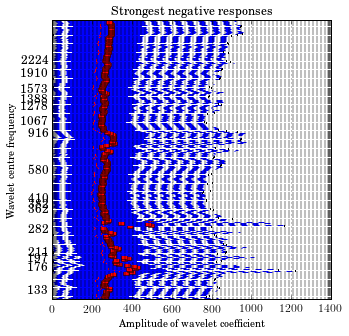

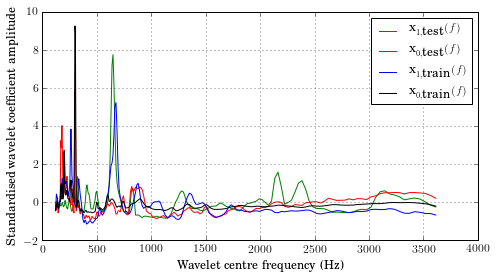

In [328]:
############### Chooose whether or not to save figure#################
save_fig = True
suffix = ''


#### Statistics of samples that trigger a high response
frac_data = 0.1
sort_index = np.argsort(predictions[:,0])
sort_index_low = np.argsort(predictions[:,1])


print 'Number of test samples', len(x_test)
n_response_samples = int(len(x_test) * frac_data)
print 'Number of high response samples,', n_response_samples, 'percentage of test data', frac_data * 100, '%'

high_response_samples = x_test[sort_index[(len(sort_index) - n_response_samples):]]
low_response_samples = x_test[sort_index_low[(len(sort_index_low) - n_response_samples):]]

print 'Number of high response samples', n_response_samples, 'data shape', np.shape(high_response_samples)
#plot amplitude vs frequency for 1 dimensional signal bin?
#plt.plot(spec_freq or wav_freq, )
if conv:
    high_response_samples = high_response_samples.reshape([high_response_samples.shape[0]*high_response_samples.shape[-1],
                                                         high_response_samples.shape[-2]])
    low_response_samples = low_response_samples.reshape([low_response_samples.shape[0]*low_response_samples.shape[-1],
                                                         low_response_samples.shape[-2]])

print 'reshaped', np.shape(high_response_samples)
high_response_samples = np.fliplr(high_response_samples)
low_response_samples = np.fliplr(low_response_samples)


# With python's cwt peak finder
function_points = np.mean(high_response_samples[:50], axis = 0) # pick top 50 detections
ind = find_peaks_cwt(function_points, np.arange(1,3),min_length=1.5) # filter out fewer labels

function_points_low = np.mean(low_response_samples[:50], axis = 0) # pick top 50 detections
ind_low = find_peaks_cwt(function_points_low, np.arange(1,3),min_length=1.5) # filter out fewer labels

# High sample box plot
d = np.zeros(len(wav_freq)).astype(str)
d[ind] = np.round(wav_freq[ind]).astype(int)
d[np.where(d == '0.0')] = ''
print 'y_ticklabels', d[::-1]

# plt.title('Spectrum of strongest response')
# plt.plot(wav_freq, high_response_samples[0])
# plt.xlabel('Wavelet centre frequency')
# plt.ylabel('Amplitude of wavelet coefficient')
# plt.show()

box_labels = wav_freq.astype(int)[::-1]



# f = plt.figure(figsize = (5,5))
# ax = plt.subplot()
# ax.boxplot(high_response_samples, vert = False, labels=box_labels, manage_xticks=True, showbox=True, showfliers=False,  showmeans=True,  showcaps=True)
# ax.set_yticklabels(d[::-1])#, fontsize = 12)
# ax.set_title('Strongest positive responses')
# plt.ylabel('Wavelet centre frequency')
# plt.xlabel('Amplitude of wavelet coefficient')
# plt.grid()
# if save_fig:
#     plt.savefig('../../../TexFiles/Papers/ECML/Images/WavPositive' + suffix + '.pdf')
# plt.show()


### Low sample box plot
d = np.zeros(len(wav_freq)).astype(str)
d[ind_low] = np.round(wav_freq[ind_low]).astype(int)
d[np.where(d == '0.0')] = ''
print 'y_ticklabels', d[::-1]

box_labels = wav_freq.astype(int)[::-1]



f = plt.figure(figsize = (5,5))
ax = plt.subplot()
ax.boxplot(low_response_samples, vert = False, labels=box_labels, manage_xticks=True, showbox=True, showfliers=False,  showmeans=True,  showcaps=True)
ax.set_yticklabels(d[::-1])#, fontsize = 12)
ax.set_title('Strongest negative responses')
plt.ylabel('Wavelet centre frequency')
plt.xlabel('Amplitude of wavelet coefficient')
plt.grid()
# if save_fig:
#     plt.savefig('../../../TexFiles/Papers/ECML/Images/WavNegative' + suffix + '.pdf')
# plt.show()



low_response_samples = np.fliplr(low_response_samples)


label_size = 12
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size 

plt.figure(figsize = (7,4))
box_means = np.mean(high_response_samples, axis = 0)
box_means_low = np.mean(low_response_samples, axis = 0)
plt.plot(wav_freq, (box_means-np.mean(box_means))/np.std(box_means),'g', label = '$\\mathbf{x}_{1,\\textrm{test}}(f)$' )
plt.plot(wav_freq, (box_means_low-np.mean(box_means_low))/np.std(box_means_low),'r', 
         label = '$\\mathbf{x}_{0,\\textrm{test}}(f)$' )
plt.plot(wav_freq,(binned_fft -np.mean(binned_fft))/np.std(binned_fft), 'blue', label = '$\\mathbf{x}_{1,\\textrm{train}}(f)$')
plt.plot(wav_freq,(binned_fft_negative -np.mean(binned_fft_negative))/np.std(binned_fft_negative),
         'k', label = '$\\mathbf{x}_{0,\\textrm{train}}(f)$')

# plt.plot(wav_freq, (box_means-0),'b', label = 'top score means' )
# plt.plot(wav_freq, (box_means_low-0),'.r', label = 'bottom score means' )
# plt.plot(wav_freq,(binned_fft -0), 'g', label = 'mosquito mean')
# plt.plot(wav_freq,(binned_fft_negative -0), '.k', label = 'noise mean')

plt.legend(fontsize=12)
plt.grid()
plt.xlabel('Wavelet centre frequency (Hz)', fontsize = 12)
plt.ylabel('Standardised wavelet coefficient amplitude', fontsize = 12)
plt.tight_layout()
if save_fig:
    print 'saved fella m8'
    plt.savefig('../../../TexFiles/Papers/ECML/Images/MeanMosquito' + suffix + '.pdf')
plt.show()


#### CNN and MLP

In [136]:
function_points = np.mean(high_response_samples[:50], axis = 0)
indexes = peak.indexes(function_points)
ind = find_peaks_cwt(function_points, np.arange(1,4),min_length=2)
print indexes
print function_points[indexes]
plt.plot(function_points)
plt.plot(indexes, function_points[indexes],'gx', markersize = 15)
plt.plot(ind, function_points[ind],'ro', markersize = 15)



# plt.show()

# function_points = np.sin(np.linspace(0,10,100))


# indexes = peak.indexes(function_points, thres= 0)
# ind = find_peaks_cwt(function_points, np.arange(1,4))
# plt.plot(function_points)
# plt.plot(indexes, function_points[indexes],'gx', markersize = 15)
# plt.plot(ind, function_points[ind],'bx', markersize = 15)
# plt.ylim([-1.5, 1.5])

NameError: name 'peak' is not defined

# Section 3: Wavelet implementation

In [9]:
NEED TO PLACE WAVELET LIBRARY IN FOLDER TO IMPORT FROM PROC_DAT_LIB.PY

In [306]:
vis_idx = 23
end_idx = 40000

y = signal_list[vis_idx][:end_idx]
# derp derp, t only goes to 600.........
x = t[vis_idx]



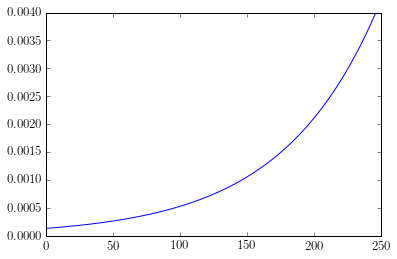

Number of wavelet scales (247,)


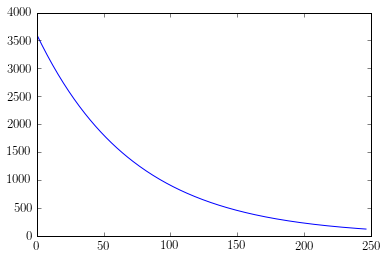

In [307]:
wav_params = np.array([3., 0.1]) # mu, sigma

#scales = bw.create_scale(200.,6000,5/(2*np.pi),fs,50) # low freq, high freq, centre freq, rate, logspacing
win_size = 40 # In samples I believe? 400 samples at 8 kHz is 0.05 seconds
scales = bw.create_scale(200.,6000, 5/(2*np.pi), fs, 50)
plt.plot(scales)
plt.show()
print 'Number of wavelet scales', np.shape(scales)

wavelet = bw.bumpcwt(scales, wav_params, y, fs)
plt.plot(wavelet.frequencies)
#bw.bumpcwt(scales, wav_params, signal, fs)

Number of wavelet scales (247,)
b padded shape (247, 40145)
cwt reshaped size (247, 155)
Reshape factor 259
(155,) (40000,)
Interpolated shape (247, 155)
True
Using label data_corrob_ac.txt
t shape post processing (57, 600)
t array shape (1, 57, 600)
Using label data_corrob_cm.txt
t shape post processing (57, 600)
t array shape (2, 57, 600)
Using label data_corrob_dz.txt
t shape post processing (57, 600)
t array shape (3, 57, 600)
Using label data_corrob_ms.txt
t shape post processing (57, 600)
t array shape (4, 57, 600)
number of specgram time windows 59
number of time labels 1875
last spectrogram time 1.888
Length of t_initial 600
Length of t_final 1875


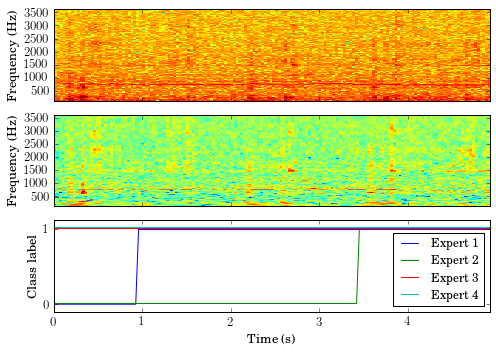

In [315]:
### http://stackoverflow.com/questions/20322079/downsample-a-1d-numpy-array
# Reference for downsampling method
maj_vote = True
count_method = 'most_positive'

fs = 8000
font_size = 13
label_size = 13
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size 

print 'Number of wavelet scales', np.shape(scales)
t_data = (np.arange(len(y), dtype = 'float32'))/fs


f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=False, figsize = (7,5))

#plt.title('Spectrogram')
res = ax1.specgram(y, Fs = fs, NFFT = 512, noverlap = 256,interpolation='nearest')
ax1.set_ylim([wavelet.frequencies[-1], wavelet.frequencies[0]])
ax1.set_xlim([0, t_data[-1]])
ax1.set_ylabel('Frequency (Hz)', fontsize = font_size)


t_initial = np.arange(len(x))
t_final = np.arange(0, len(x),1./(label_interval*fs))

t_corrected = np.interp(t_final, t_initial, x)  
            

b = wavelet.cwtcfs

# Perform binning in time-domain to match dimensions of spectrogram
R = int(np.ceil(float(np.shape(b)[1])/len(res[2]))) # Downsampling rate R
pad_size = np.ceil(float(np.shape(b)[1])/R)*R - np.shape(b)[1]


b_padded = np.hstack([b, np.zeros([b.shape[0], int(pad_size)])*np.NaN])
print 'b padded shape',b_padded.shape
rotato = b_padded.T.reshape(-1,R,b.shape[0])
cwtcfs_reshape = nanmean(np.abs(rotato), axis=1)  # Maybe take the mean of the spectrum/abs vals here instead?
cwtcfs_reshape = cwtcfs_reshape.T
print 'cwt reshaped size', cwtcfs_reshape.shape
print 'Reshape factor', R

t_wav = np.arange(cwtcfs_reshape.shape[1],dtype = 'float32')/spec_fs

#plt.figure(figsize = (15,6))
#ax2.set_title('Mean Binned CWT')
ax2.pcolormesh(t_wav,wavelet.frequencies, 10 * np.log10(cwtcfs_reshape), rasterized = True)
ax2.set_ylabel('Frequency (Hz)', fontsize = font_size)
#plt.colorbar()
ax2.set_ylim([wavelet.frequencies[-1], wavelet.frequencies[0]])
#ax2.set_xlim([t_wav[0], t_wav[-1]])
#plt.show()

xt = res[2]
xp = np.arange(b.shape[1],dtype = 'float32')/fs

print np.shape(xt), np.shape(xp)
new_coefs = np.zeros([b.shape[0], len(res[2])])
print 'Interpolated shape', np.shape(new_coefs)
for i, coefs in enumerate(b):    
    new_coefs[i,:] = np.interp(xt,xp, np.abs(coefs))
cwtcfs_reshape = new_coefs

t_wav = np.arange(cwtcfs_reshape.shape[1],dtype = 'float32')/spec_fs


#ax3.plot((t_final * label_interval)[:end_idx], t_corrected[:end_idx], 'g')
#ax3.xlim([t_wav[0], t_wav[-1]])

f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

t_array = []

ii = vis_idx  # Index for visualisation
#lines = ['r--','bs','g^','kx']

if maj_vote:
    print maj_vote
    for idx, who in enumerate([0,4,5,6]):
        t = []    

        print 'Using label', label_names[who]
        for index, item in enumerate(label_list[who]):
            t_entry = [float(i) for i in item]
            t.append(t_entry[:len(signal_list[index-1])])    # -1 Corrects for extra label present

        t = np.delete(t, (0), axis = 0)
        t_array.append(np.array(t))
        print 't shape post processing', np.shape(t.squeeze())

        print 't array shape', np.shape(t_array)


        t_initial = np.arange(0, len(t[ii]))
        t_final = np.arange(0, len(t[ii]),1./(label_interval*spec_fs))
        t_corrected = np.interp(t_final, t_initial, t[ii])
        t_corrected = np.rint(t_corrected)

        ax3.plot((t_final/(1./label_interval))[:end_idx] , t_corrected[:end_idx]+ 0.01 * idx)

    print 'number of specgram time windows', len(im[2])
    print 'number of time labels', len(t_corrected)
    print 'last spectrogram time', im[2][-1]
    print 'Length of t_initial', len(t[ii])
    print 'Length of t_final', len(t_corrected)

    t = np.zeros([57,600])

    t_array = np.array(t_array)
    for j in range(np.shape(t_array)[1]):
        for i in range(np.shape(t_array)[2]):
            count = Counter(t_array[:,j,i])
            if count_method == 'two_or_more':
                if count[0] == count[1]:  # Tiebreak
                    t[j,i] = 1.  # As a result, 2 or more 1s are classified as 1
                else:
                    t[j,i] = count.most_common()[0][0]
            elif count_method == 'agreement':
                if max([count[0], count[1]]) == 4:
                    t[j,i] = np.argmax([count[0], count[1]])
                else:
                    t[j,i] = 3.
                    #remove sample marked as 3.
            elif count_method == 'most_positive':
                if count[1] >= 1:  # If any label predicts a 1, classify as 1
                    t[j,i] = 1.  
                else:
                    t[j,i] = 0.
            else:
                raise ValueError('Specified count method does not exist')
              

    t_final = np.arange(0, len(t[ii]),1./(label_interval*spec_fs))
    t_corrected = np.interp(t_final, t_initial, t[ii])
    t_corrected = np.rint(t_corrected)
    #ax3.plot(t_final/(1./label_interval), t_corrected, '.-')
    #plt.legend([label_names[0], label_names[4], label_names[5], label_names[6], count_method], loc=2,prop={'size':6})

#   Edited legend to conform to LaTeX labels
    plt.legend(['Expert 1', 'Expert 2', 'Expert 3', 'Expert 4'], loc=4,prop={'size':12})
#     plt.legend([label_names[0], label_names[4], label_names[5], label_names[6]], loc=2,prop={'size':4})
    plt.xlabel('Time (s)', fontsize = font_size)
    plt.xlim([t_wav[0], t_wav[-1]])
    plt.ylim([-0.1, 1.125])
    ax3.set_yticks([0, 1])
    ax3.set_ylabel("Class label", fontsize = font_size)
plt.tight_layout()    
plt.savefig('../../../TexFiles/Papers/ECML/Images/DataLabel' + '.pdf')
plt.show()

In [ ]:
## Running bumpwavelet with minimal memory footprint. Original implementation very memory ineffecient
x_train = []
y_train = []

for index, item in enumerate(train_x):
    print 'Processing index', index, 'of', len(train_x)
    x_train_wav, y_train_wav, input_shape = proc_data_bumpwav(train_x[index:index+1], train_t[index:index+1], fs, img_height=-1, 
        img_width = 10 , label_interval=0.1, binning = binning_method)
    #x_train = np.vstack([[x_train_wav], x_train])
    #y_train = np.vstack([[y_train_wav], y_train])
    x_train.append(x_train_wav)
#x_train_wav_2, y_train_wav_2, input_shape = proc_data_bumpwav(train_x[23:24], train_t[23:24], fs, img_height=-1, img_width = 400 , label_interval=0.1)
#x_test_wav_2, y_test_wav_2, input_shape = proc_data_bumpwav(test_x[3:4], test_t[3:4], fs, img_height=-1, img_width = 40 , label_interval=0.1)

Processing index 0 of 38
Working on index 0
Finished wavelet transform for index 0
Processing signal number 0
Length of cwt 434176
Number of training inputs for this signal: 1085

x dimensions before reshape (1085, 107, 400)


Working on index 0
Finished wavelet transform for index 0
interp-binning in time domain
Interpolated shape (247L, 1695L)
Working on index 1
Finished wavelet transform for index 1
interp-binning in time domain
Interpolated shape (247L, 1695L)
Working on index 2
Finished wavelet transform for index 2
interp-binning in time domain
Interpolated shape (247L, 1695L)
Working on index 3
Finished wavelet transform for index 3
interp-binning in time domain
Interpolated shape (247L, 1695L)
Working on index 4
Finished wavelet transform for index 4
interp-binning in time domain
Interpolated shape (247L, 1695L)
Working on index 5
Finished wavelet transform for index 5
interp-binning in time domain
Interpolated shape (247L, 1695L)
Working on index 6
Finished wavelet transform for index 6
interp-binning in time domain
Interpolated shape (247L, 1695L)
Working on index 7
Finished wavelet transform for index 7
interp-binning in time domain
Interpolated shape (247L, 1695L)
Working on index 8
Finished wave

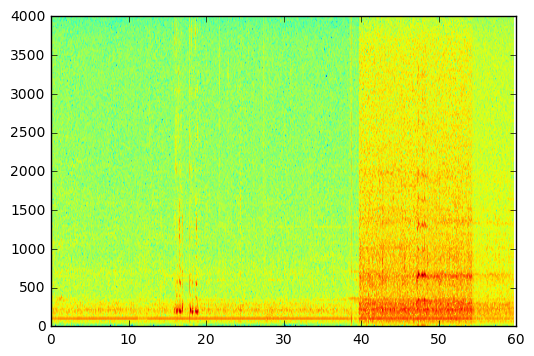

In [11]:
img_width = 1
binning_method = 'interp'

x_train_wav, y_train_wav, input_shape = proc_data_bumpwav(train_x, train_t, fs, img_height=len(scales), 
    img_width = img_width , label_interval=0.1, binning = binning_method)
x_test_wav, y_test_wav, input_shape = proc_data_bumpwav(test_x, test_t, fs, img_height=len(scales), 
    img_width = img_width , label_interval=0.1, binning = binning_method)

## Cross-validation data processing

In [43]:
folds = 10
kernel_sizes = [[2,2],[3,3],[4,4],[5,5]]
dense_sizes = [16,64,128,256]
nb_filters = [8,16,32]

# Shuffle training and test datasets
acc_test_full_wav, acc_full_wav, val_acc_full_wav = SOMETHING.crossval(x_train, y_train, kernel_sizes = kernel_sizes, filter_numbers = nb_filters,
                                  dense_numbers = dense_sizes, max_epoch = 20, folds = 10)


(62282L, 256L)
(32844L, 256L)


In [ ]:
############### MLP XVAL SPEC ################################

folds = 10
kernel_sizes = [[1,1]]
dense_sizes = [64,128,256,512,1024]
nb_filters = [8,32,128,1024,2048]
n_hidden = [8,32,128,256,1028,2056]

xval_dict = SOMETHING.crossval_MLP(x_train, y_train, kernel_sizes = kernel_sizes, filter_numbers = n_hidden,
                                  dense_numbers = dense_sizes, max_epoch = 20, folds = 10)


Accuracy
0.837046419484
0.815763106021
0.845691654497
0.813079262843
0.843427766086
0.805868670873
0.843095943204
0.812828770697
0.85247796768
0.802719627783
0.870308987726
0.857613168653
0.881541014005
0.871783861626
0.886718164661
0.88708176732
0.89268384058
0.896743603445
0.891691939955
0.901037752646
0.854540264721
0.888870996556
0.880973703945
0.886884952521
0.886425589583
0.887368044119
0.889319227932
0.899821076992
0.891964890963
0.907729468641
0.86197416778
0.886222937683
0.872970706829
0.883932725074
0.883945837928
0.89470388279
0.885290969427
0.893880837399
0.886875156094
0.890212917983
0.873873407742
0.890874932842
0.87246226854
0.886115584116
0.881111071477
0.881893003846
0.882470474881
0.889533011493
0.876112320278
0.885095723427
0.873546936899
0.878726068835
0.865190708969
0.886115584037
0.877544867459
0.875398103231
0.881128911408
0.854034711075
0.802508295616
0.87563070314
index of highest metric: 29
value 0.907729468641
[8, 32, 128, 256, 1028, 2056]
[64, 128, 256, 512,

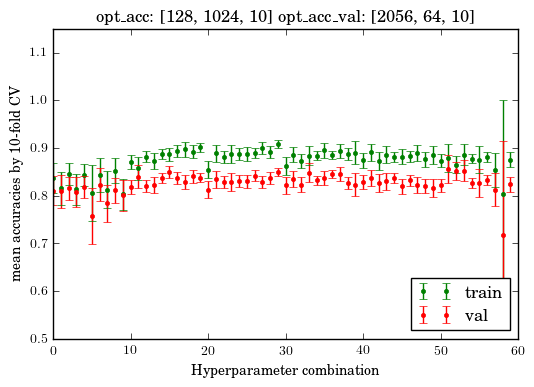

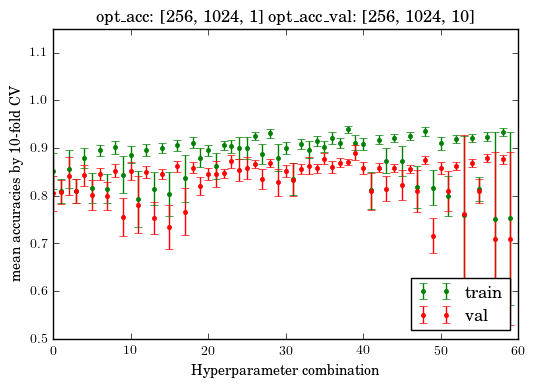

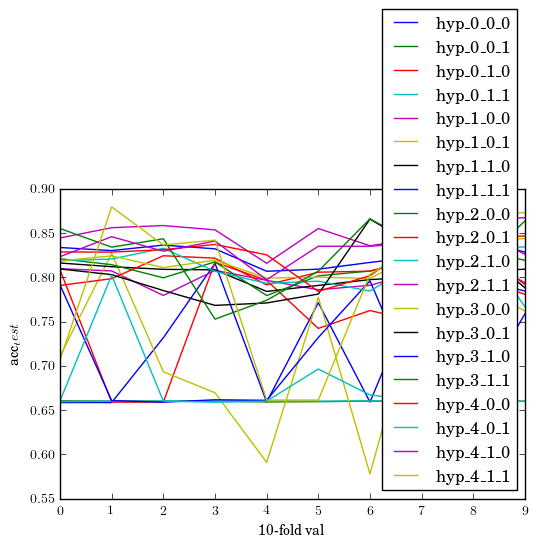

In [221]:
###################################
save_fig = False
###################################

acc_test = np.array(xval_spec["acc_test"])
acc = np.array(xval_spec["acc"])
val_acc = np.array(xval_spec["val_acc"])

kernel_sizes = xval_spec["kernel_sizes"]



print 'Accuracy'
hyp_opt_acc = retrieve_hyp_opt(acc, n_hidden, dense_sizes,kernel_sizes= kernel_sizes)
print 'Validation Accuracy'
hyp_opt_val_acc = retrieve_hyp_opt(val_acc, n_hidden, dense_sizes,kernel_sizes= kernel_sizes)
print 'Test Accuracy'
hyp_opt_acc_test = retrieve_hyp_opt(acc_test, n_hidden, dense_sizes,kernel_sizes= kernel_sizes)

plot_acc_mean([acc, val_acc], n_hidden, dense_sizes,kernel_sizes= kernel_sizes)
plt.ylim([0.5,1.15])
if save_fig:
    plt.savefig('../../../TexFiles/Papers/ECML/Images/xval_MLP_spec.pdf')

    
acc_test = np.array(xval_wav["acc_test"])
acc = np.array(xval_wav["acc"])
val_acc = np.array(xval_wav["val_acc"])
    
    
    
print 'Accuracy'
hyp_opt_acc = retrieve_hyp_opt(acc, n_hidden, dense_sizes,kernel_sizes= kernel_sizes)
print 'Validation Accuracy'
hyp_opt_val_acc = retrieve_hyp_opt(val_acc, n_hidden, dense_sizes,kernel_sizes= kernel_sizes)
print 'Test Accuracy'
hyp_opt_acc_test = retrieve_hyp_opt(acc_test, n_hidden, dense_sizes,kernel_sizes= kernel_sizes)

plot_acc_mean([acc, val_acc], n_hidden, dense_sizes,kernel_sizes= kernel_sizes)
plt.ylim([0.5,1.15])
if save_fig:
    plt.savefig('../../../TexFiles/Papers/ECML/Images/xval_MLP_wav.pdf')
        
    
    
# ### Wavelet processing #####

# acc = np.array(acc_full_wav)
# val_acc = np.array(val_acc_full_wav)
# acc_test = np.array(acc_test_full_wav)


# print 'Accuracy'
# hyp_opt_acc = retrieve_hyp_opt(acc, n_hidden, dense_sizes,kernel_sizes= ' ')
# print 'Validation Accuracy'
# hyp_opt_val_acc = retrieve_hyp_opt(val_acc, n_hidden, dense_sizes,kernel_sizes= ' ')
# print 'Test Accuracy'
# hyp_opt_acc_test = retrieve_hyp_opt(acc_test, n_hidden, dense_sizes,kernel_sizes= ' ')

# plot_acc_mean([acc, val_acc], n_hidden, dense_sizes,kernel_sizes= ' ')
# if save_fig:
#     plt.savefig('../../../TexFiles/Papers/ECML/Images/xval_MLP.pdf')

# print 'Accuracy'
# hyp_opt_acc = retrieve_hyp_opt(acc, nb_filters = [8,16,32], dense_sizes = [16,64,128,256], 
#                                kernel_sizes = [[2,2],[3,3],[4,4],[5,5]])
# print 'Validation Accuracy'
# hyp_opt_val_acc = retrieve_hyp_opt(val_acc, nb_filters = [8,16,32], dense_sizes = [16,64,128,256], 
#                                kernel_sizes = [[2,2],[3,3],[4,4],[5,5]])
# print 'Test Accuracy'
# hyp_opt_acc = retrieve_hyp_opt(acc_test, nb_filters = [8,16,32], dense_sizes = [16,64,128,256], 
#                                kernel_sizes = [[2,2],[3,3],[4,4],[5,5]])

# plot_acc_mean([acc, val_acc], nb_filters = [8,16,32], dense_sizes = [16,64,128,256], 
#                                kernel_sizes = [[2,2],[3,3],[4,4],[5,5]])
# plt.ylim([0.5,1.15])
# if save_fig:
#     plt.savefig('../../../TexFiles/Papers/ECML/Images/xval_spec.pdf')



# plot_acc_mean(val_acc, 'val_acc')
# plot_acc_mean(acc_test, 'acc_test')


# plt.figure()
# for i in range(len(nb_filters)):
#     for j in range(len(dense_sizes)):
#         for k in range(len(kernel_sizes)):
#             print 'index, acc', idx, np.mean(acc[i,j,k])
#             plt.plot(acc[i,j,k], label ='hyp_%i_%i_%i'%(i,j,k))            
# plt.legend(loc = 4)
# plt.xlabel('10-fold val')
# plt.ylabel('acc')


# plt.figure()
# for i in range(len(nb_filters)):
#     for j in range(len(dense_sizes)):
#         for k in range(len(kernel_sizes)):
#             plt.plot(val_acc[i,j,k], label ='hyp_%i_%i_%i'%(i,j,k))
# plt.legend(loc = 4)
# plt.xlabel('10-fold val')
# plt.ylabel('val_acc')

plt.figure()
for i in range(len(nb_filters)):
    for j in range(len(kernel_sizes)):
        for k in range(len(kernel_sizes)):
            plt.plot(acc_test[i,j,k], label ='hyp\_%i\_%i\_%i'%(i,j,k))
plt.legend(loc = 4)
plt.xlabel('10-fold val')
plt.ylabel('acc_test')


